## OpenRLHF 介绍

OpenRLHF 是一个基于 Ray、DeepSpeed 和 HF Transformers 构建的高性能大模型强化学习框架，具有以下优点：

1. 简单易用：无缝兼容 Huggingface 模型和数据集，成为目前可用的最简单的高性能 RL 库之一。现在也支持从 ModelScope 上获取模型和数据集。
2. 高性能：RLHF 训练中 80% 的时间用于样本生成阶段。得益于使用 Ray, Packing Samples 以及 vLLM 生成加速的能力，OpenRLHF 的性能是极致优化的 DeepSpeedChat with Hybrid Engine 的3~4倍以上。
3. 分布式：OpenRLHF 使用 Ray 将 Actor、Reward、Reference 和 Critic 模型分布到不同的 GPU 上，同时将 Adam 优化器放在 CPU 上。这使得使用多个 A100 80G GPU 和 vLLM 可以全面微调超过 70B+ 的模型 以及在多个 24GB RTX 4090 GPU 上微调 7B 模型。
4. PPO 实现技巧：OpenRLHF 集成了若干 PPO 的实现技巧以提高训练稳定性。

目前有一些 DeepSeek-R1 复刻项目就是基于 OpenRLHF 库，如：[simpleRL-reason](https://github.com/hkust-nlp/simpleRL-reason)。

### OpenRLHF 安装

OpenRLHF 官方推荐启动 Docker 镜像后，在镜像内安装。当然您也可以直接使用下面的命令安装。


In [ ]:
# pip install
pip install openrlhf

# 如果需要使用 vLLM 加速 (安装 vLLM 0.7.2)
pip install openrlhf[vllm]
# 最新的 vLLM 也是支持的
pip install openrlhf[vllm_latest]

# pip install GitHub 上的最新版
pip install git+https://github.com/OpenRLHF/OpenRLHF.git

# 或者 git clone
git clone https://github.com/OpenRLHF/OpenRLHF.git
cd OpenRLHF
pip install -e .

### OpenRLHF 使用

OpenRLHF 的模型检查点完全兼容 HuggingFace 模型。您可以使用 `--pretrain  {name or path}`、`--reward_pretrain  {name or path}` 和 `--critic_pretrain  {name or path}` 指定模型名称或路径。现在您也可以添加一个 `--use_ms` 来指定从 ModelScope 上获取模型和数据集。

In [ ]:
CUDA_VISIBLE_DEVICES=0,1,2,3

deepspeed --module openrlhf.cli.train_sft \
   --max_len 4096 \
   --dataset AI-ModelScope/OpenOrca \
   --input_key question \
   --output_key response \
   --input_template $'User: {}\nAssistant: ' \
   --train_batch_size 256 \
   --micro_train_batch_size 2 \
   --max_samples 500000 \
   --pretrain LLM-Research/Meta-Llama-3-8B \
   --save_path ./checkpoint/llama3-8b-sft \
   --save_steps -1 \
   --logging_steps 1 \
   --eval_steps -1 \
   --zero_stage 2 \
   --max_epochs 1 \
   --bf16 \
   --flash_attn \
   --learning_rate 5e-6 \
   --gradient_checkpointing \
   --packing_samples \
   --load_checkpoint \
   --use_wandb {wandb_token} \
   --use_ms

除了 SFT 训练，OpenRLHF 的 PPO、DPO、KTO 等训练方法，以及 batch_inference、serve_rm 等部署方法也都支持了使用 `--use_ms` 的方式从 ModelScope 上获取模型及数据集。如果 ModelScope 上没有所需的模型或者数据集，也可以自行上传。

OpenRLHF 给出了一些数据集相关的参数，比如 `--input_key` 和 `--output_key` 用于指定 JSON key name 为数据集的输入输出，方便兼容不同的数据集而节省事先处理数据集的时间。比如在上面的演示中，我们就指定了数据集中应该被使用的 Key 是 'question' 和 'response'。更多详细的设置，可以访问官方文档。

In [ ]:
CUDA_VISIBLE_DEVICES=4,5,6,7

deepspeed --master_port 61000 \
  openrlhf/cli/train_ppo.py \
  --pretrain AI-ModelScope/Llama-3-8b-sft-mixture \
  --reward_pretrain AI-ModelScope/Llama-3-8b-rm-mixture \
  --save_path ./checkpoint/llama-3-8b-rlhf \
  --save_steps -1 \
  --logging_steps 1 \
  --eval_steps -1 \
  --micro_train_batch_size 2 \
  --train_batch_size 128 \
  --micro_rollout_batch_size 4 \
  --rollout_batch_size 1024 \
  --max_epochs 1 \
  --prompt_max_len 1024 \
  --generate_max_len 1024 \
  --zero_stage 2 \
  --bf16 \
  --actor_learning_rate 5e-7 \
  --critic_learning_rate 9e-6 \
  --init_kl_coef 0.01 \
  --prompt_data AI-ModelScope/prompt-collection-v0.1 \
  --input_key context_messages \
  --apply_chat_template \
  --max_samples 100000 \
  --normalize_reward \
  --adam_offload \
  --flash_attn \
  --gradient_checkpointing \
  --load_checkpoint \
  --use_wandb {wandb_token} \
  --use_ms

上述命令在 NVIDIA A100-SXM4-80GB * 8 上训练 36 小时得到的结果如下：

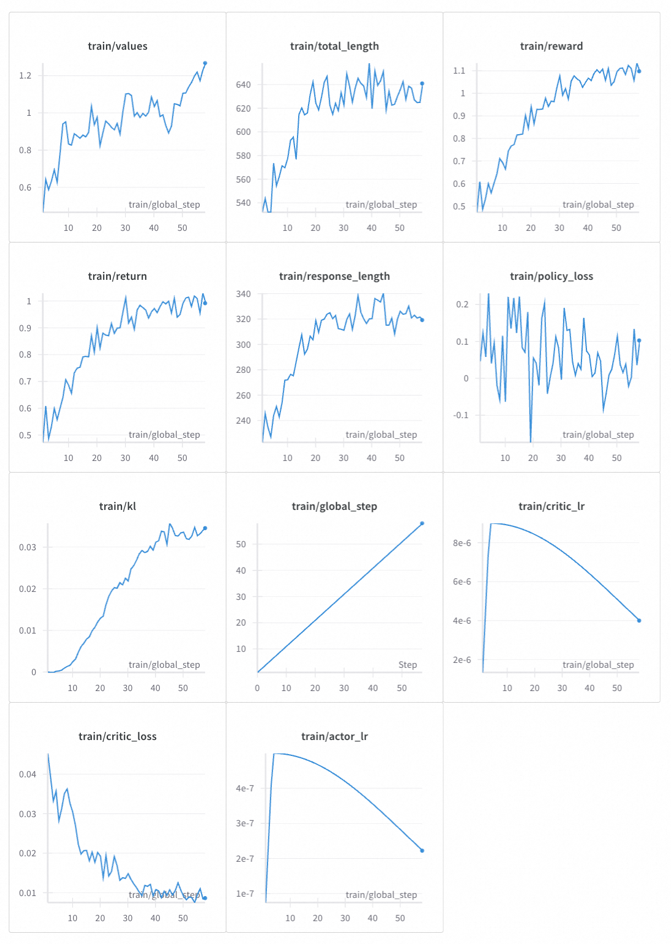